# Problem Set 2, due April 27th at 3:30 pm

**Please Note:** This assignment will likely take you a _long_ time, especially if you are new to Python. Start early!

## Introduction to the assignment

For this assignment, you will be using data from the [Progresa program](http://en.wikipedia.org/wiki/Oportunidades), a government social assistance program in Mexico. This program, as well as the details of its impact, are described in the paper "[School subsidies for the poor: evaluating the Mexican Progresa poverty program](http://www.sciencedirect.com/science/article/pii/S0304387803001858)", by Paul Shultz (available on Canvas). Please familiarize yourself with the PROGRESA program before beginning this problem set, so you have a rough sense of where the data come from and how they were generated. If you just proceed into the problem set without understanding Progresa or the data, it will be very difficult!

The goal of this problem set is to implement some of the basic econometric techniques that you are learning in class to measure the impact of Progresa on secondary school enrollment rates. The timeline of the program was:

 * Baseline survey conducted in 1997
 * Intervention begins in 1998, "Wave 1" of data collected in 1998
 * "Wave 2 of data" collected in 1999
 * Evaluation ends in 2000, at which point the control villages were treated. 
 
When you are ready, download the progresa_sample.csv data from Canvas. The data are actual data collected to evaluate the impact of the Progresa program.  In this file, each row corresponds to an observation taken for a given child for a given year. There are two years of data (1997 and 1998), and just under 40,000 children who are surveyed in each year. For each child-year observation, the following variables are collected:

| Variable name | Description|
|---------|---------|
|year	  |year in which data is collected
|sex	  |male = 1|
|indig	  |indigenous = 1|
|dist_sec |nearest distance to a secondary school|
|sc	      |enrolled in school in year of survey|
|grc      |grade enrolled|
|fam_n    |family size|
|min_dist |	min distance to an urban center|
|dist_cap |	min distance to the capital|
|poor     |	poor = 'pobre'|
|progresa |treatment = 'basal'|
|hohedu	  |years of schooling of head of household|
|hohwag	  |monthly wages of head of household|
|welfare_index|	welfare index used to classify poor|
|hohsex	  |gender of head of household (male=1)|
|hohage   |age of head of household|
|age      |years old|
|folnum	  |individual id|
|village  |	village id|
|sc97	  |schooling in 1997|

In [201]:
import sys; print(sys.version)
%matplotlib inline
import IPython
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
import sklearn as sk
import statsmodels.formula.api as sm
from sklearn.linear_model import LinearRegression
import pylab

3.5.2 |Anaconda 4.2.0 (64-bit)| (default, Jul  5 2016, 11:41:13) [MSC v.1900 64 bit (AMD64)]


---
##Part 1: Descriptive analysis

### 1.1	Summary Statistics

a) Present number of missing observations for every single variable


In [202]:
progresa_df=pd.read_csv("C:/Users/jakum/Documents/Quarter 3/ml/assignments/progresa_sample/progresa_sample.csv")
progresa_df.fillna(0)
print("year:",(progresa_df['year'].isnull().sum()))
print("sex:",(progresa_df['sex'].isnull().sum()))
print("indig:",(progresa_df['indig'].isnull().sum()))
print("dist_sec:",(progresa_df['dist_sec'].isnull().sum()))
print("sc:",(progresa_df['sc'].isnull().sum()))
print("grc:",(progresa_df['grc'].isnull().sum()))
print("fam_n:",(progresa_df['fam_n'].isnull().sum()))
print("min_dist:",(progresa_df['min_dist'].isnull().sum()))
print("dist_Cap:",(progresa_df['dist_cap'].isnull().sum()))
print("poor:",(progresa_df['poor'].isnull().sum()))
print("progresa:",(progresa_df['progresa'].isnull().sum()))
print("hohedu:",(progresa_df['hohedu'].isnull().sum()))
print("hohwag:",(progresa_df['hohwag'].isnull().sum()))
print("welfare_index:",pd.value_counts(progresa_df['welfare_index'].isnull().sum()))
print("hohsex:",(progresa_df['hohsex'].isnull().sum()))
print("hohage:",(progresa_df['hohage'].isnull().sum()))
print("age:",(progresa_df['age'].isnull().sum()))
print("folnum:",(progresa_df['folnum'].isnull().sum()))
print("village:",(progresa_df['village'].isnull().sum()))
print( "sc97:",progresa_df['sc97'].isnull().sum())


year: 0
sex: 24
indig: 300
dist_sec: 0
sc: 8453
grc: 6549
fam_n: 0
min_dist: 0
dist_Cap: 0
poor: 0
progresa: 0
hohedu: 0
hohwag: 0
welfare_index: 210    1
dtype: int64
hohsex: 20
hohage: 10
age: 0
folnum: 0
village: 0
sc97: 3872


b) Present summary statistics (mean and standard deviation) for all of the demographic variables in the dataset (i.e., everything except year, folnum, village). Present these in a single table alphabetized by variable name. Do NOT simply expect the grader to scroll through your output!

In [203]:
progresa_df.columns
summary_tab=pd.DataFrame(index=range(16),columns=['variable','mean','standard_deviation'])
i=0
for column in progresa_df:
    if((column != 'year')&(column !='folnum')&(column !='village')&(column != 'poor')&(column != 'progresa')):
        temp=pd.Series(progresa_df.loc[:,column])
        mean_v=np.mean(temp)
        stdi=np.std(temp)
        summary_tab.iloc[i]=dict(variable=column,mean=mean_v,standard_deviation=stdi)
        i=i+1
        
print (summary_tab.sort_values(by='variable').to_string(index=False))

        


variable      mean standard_deviation
          age   11.3665            3.16772
     dist_cap   147.674            76.0626
     dist_sec   2.41891            2.23409
        fam_n   7.21572            2.35289
          grc   3.96354            2.49905
        grc97   3.70537            2.57237
       hohage   44.4367            11.6203
       hohedu    2.7681            2.65609
       hohsex  0.925185           0.263093
       hohwag   586.985            788.129
        indig  0.298324           0.457522
     min_dist   103.448            42.0892
           sc  0.819818           0.384339
         sc97  0.813922           0.389169
          sex  0.512211           0.499851
welfare_index   690.347             139.49


### 1.2 Differences at baseline?

Are the baseline (1997) demographic characteristics **for the poor**  different in treatment and control villages? Hint: Use a T-Test to determine whether there is a statistically significant difference in the average values of each of the variables in the dataset. Focus only on the data from 1997 for individuals who are poor (i.e., poor=='pobre').

Present your results in a single table with the following columns and 14 (or so) rows:

| Variable name | Average value (Treatment villages) | Average value (Control villages) | Difference (Treat - Control) | p-value |
|------|------|------|------|------|
|Male  |?     |?     |?     |?     |


In [204]:
baseline_df=pd.DataFrame(index=range(1,16),columns=['variable_name', 'avg_valt','avg_valc','diff','p_val'])
i=1
for column in progresa_df:
    if((column != 'year')&(column !='folnum')&(column !='village')&(column != 'poor')&(column != 'progresa')):
        temp1=pd.Series(progresa_df.loc[:,column].where((progresa_df['poor']=="pobre")&(progresa_df['progresa']=="basal")&(progresa_df['year']==97)))
        mean_t=np.mean(temp1)
        temp2=pd.Series(progresa_df.loc[:,column].where((progresa_df['poor']=="pobre")&(progresa_df['progresa']=="0")&(progresa_df['year']==97)))
        mean_c=np.mean(temp2)
        (tval,pval)=sp.stats.ttest_ind(temp1,temp2,equal_var = False,nan_policy='omit')
        baseline_df.loc[i]=dict(variable_name=column,avg_valt=mean_t,avg_valc=mean_c,diff=(mean_t-mean_c),p_val=pval)
        i=i+1
print (baseline_df.to_string(index=False))

        

variable_name  avg_valt  avg_valc        diff        p_val
          sex  0.519317  0.505052   0.0142652    0.0122074
        indig  0.325986  0.332207 -0.00622198     0.245902
     dist_sec   2.45312   2.50766  -0.0545398    0.0426628
           sc  0.822697  0.815186  0.00751088    0.0964612
          grc    3.5316   3.54305  -0.0114503     0.689523
        fam_n   7.28133   7.30247  -0.0211419     0.428967
     min_dist   107.153   103.238     3.91506   7.0558e-16
     dist_cap   150.829    153.77    -2.94066   0.00114648
       hohedu   2.66314   2.59035   0.0727912    0.0103822
       hohwag    544.34   573.164     -28.824  0.000328729
welfare_index   655.428   659.579    -4.15072   0.00153168
       hohsex  0.924656  0.922947  0.00170878     0.572125
       hohage   43.6488   44.2769    -0.62809  2.25946e-06
          age    10.717    10.742   -0.025032     0.478363
        grc97    3.5316   3.54305  -0.0114503     0.689523
         sc97  0.822697  0.815186  0.00751088    0.09646

### 1.3 Interpretation

* A: Are there statistically significant differences between treatment and control villages as baseline? 
* B: Why does it matter if there are differences at baseline?
* C: What does this imply about how to measure the impact of the treatment?

In [205]:
#A: Null Hyp: there is no statistical difference
# alt hyp: there is statistical difference
#Here, if choosen p value as 0.10
print("alpha=0.10: \n",baseline_df.where(baseline_df.p_val<0.10).dropna())
#if p=0.05
print("\n alpha=0.01\n",baseline_df.where(baseline_df.p_val<0.010).dropna())
#proceeding with alpha = 0.01 

alpha=0.10: 
     variable_name  avg_valt  avg_valc        diff        p_val
1             sex  0.519317  0.505052   0.0142652    0.0122074
3        dist_sec   2.45312   2.50766  -0.0545398    0.0426628
4              sc  0.822697  0.815186  0.00751088    0.0964612
7        min_dist   107.153   103.238     3.91506   7.0558e-16
8        dist_cap   150.829    153.77    -2.94066   0.00114648
9          hohedu   2.66314   2.59035   0.0727912    0.0103822
10         hohwag    544.34   573.164     -28.824  0.000328729
11  welfare_index   655.428   659.579    -4.15072   0.00153168
13         hohage   43.6488   44.2769    -0.62809  2.25946e-06
16           sc97  0.822697  0.815186  0.00751088    0.0964612

 alpha=0.01
     variable_name avg_valt avg_valc     diff        p_val
7        min_dist  107.153  103.238  3.91506   7.0558e-16
8        dist_cap  150.829   153.77 -2.94066   0.00114648
10         hohwag   544.34  573.164  -28.824  0.000328729
11  welfare_index  655.428  659.579 -4.15072   

A: Are there statistically significant differences between treatment and control villages as baseline? 

The following factors have significant difference between treatment and control villages : minimum distance to urban center, minimum distance to capital, monthly wages of head of household, house head age,welfare index used to classify poor.

B: Why does it matter if there are differences at baseline?

It is important that there is minimal difference between treatment and control groups in a randomized trial. If the treatment and control groups are not equal to start, the results will have the influence of confounding variables. for example, here we see welfare index to have a significant difference. Given the welfare index is an important factor that decides if the family gets progresa, the difference should ideally not be significant.

C: What does this imply about how to measure the impact of the treatment?
As dscussed above, as we know some important factors are statistically significant differences between control and treatment groups, care has to be taken to account these difference while interpreting the results and while developing the model, these difference should be controlled for.


### 1.4 Graphical exploration, part 1

For each level of household head education, compute the average enrollment rate in 1997. Create a scatterplot that shows this relationship. What do you notice?

(1, 20)

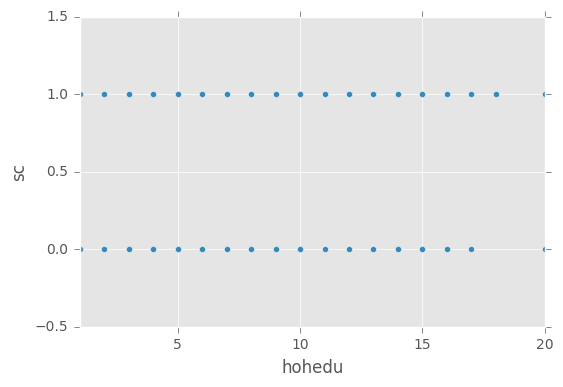

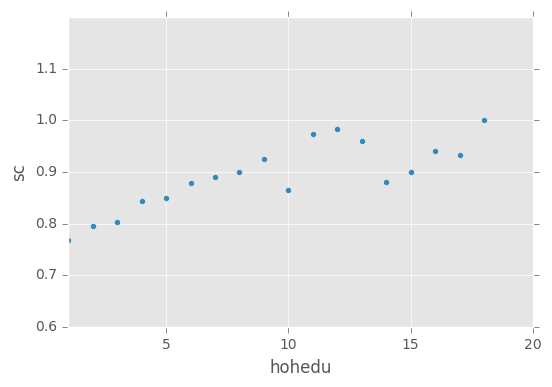

In [206]:
#progresa_df.plot.scatter(x='hohedu',y='sc')
#plotting without mean
avg_enrol=pd.DataFrame(progresa_df.where(progresa_df.year==97))
matplotlib.style.use('ggplot')
avg_enrol.plot.scatter(x='hohedu',y='sc',use_index=True)
plt.ylim([-0.5,1.5])
plt.xlim([1,20])
#plotting average enrollment rate
avg_enrol=avg_enrol.groupby(avg_enrol.hohedu).mean()
avg_enrol.reset_index().plot.scatter(x='hohedu',y='sc',use_index=True)
plt.ylim([0.6,1.2])
plt.xlim([1,20])

The general trend is that, as household education goes up enrollment rate increases. But there are few point that indicate otherwise. Two significant dips can be observed. When the hohedu value is 10 and when it is 15, the enrollment rate sinks contrary to the trend.

### 1.5 Graphical exploration, part 2

Create a histogram of village enrollment rates **among poor households in treated villages**, before and after treatment. Specifically, for each village, calculate the average rate of enrollment of poor households in treated villages in 1997, then compute the average rate of enrollment of poor households in treated villages in 1998. Create two separate histograms showing the distribution of these average enrollments rates, one histogram for 1997 and one histogram for 1998. On each histogram, draw a vertical line that intersects the x-axis at the average value (across all households).
* Does there appear to be a difference? Is this difference statistically significant?
* Which D estimator in Schultz (2004) does this approach correspond to?

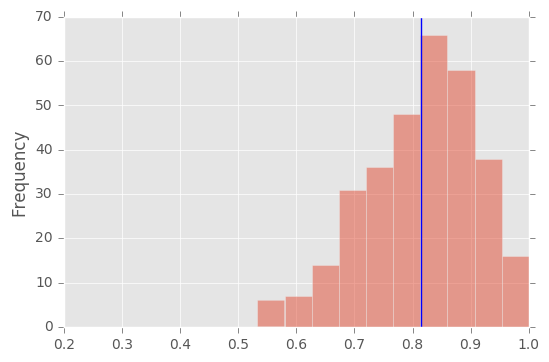

0.0442493434226


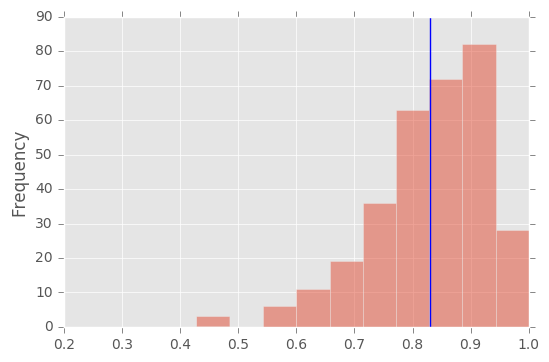

In [207]:
#for 97
avg_enrol_b=pd.DataFrame(progresa_df.where((progresa_df.year==97)&(progresa_df.poor== 'pobre')&(progresa_df.progresa== 'basal')))
avg_enrol_b=avg_enrol_b.groupby(avg_enrol_b.village).mean()
avg_enrol_b['sc'].plot.hist(alpha=0.5)
plt.xlim([0.2,1])
plt.axvline(avg_enrol_b.sc.mean(),color = 'blue')
plt.show()
#for 98
avg_enrol_a=pd.DataFrame(progresa_df.where((progresa_df.year==98)&(progresa_df.poor== 'pobre')&(progresa_df.progresa== 'basal')))
avg_enrol_a=avg_enrol_a.groupby(avg_enrol_a.village).mean()
avg_enrol_a['sc'].plot.hist(alpha=0.5)
plt.xlim([0.2,1])
plt.axvline(avg_enrol_a.sc.mean(),color = 'blue')
# for statistical difference
(tval,pval)=sp.stats.ttest_ind(avg_enrol_b.sc,avg_enrol_a.sc,equal_var = False)
print(pval)

p val for t-test between the average means for poor villages in 97 and 98 is not less that 0.01(the set alpha value for this analysis). Therefore, the difference is not statistically significant.

## Part 2: Measuring Impact

### 2.1 Simple differences: T-test

Start out by estimating the impact of Progresa using "simple differences." Restricting yourself to data from 1998 (after treatment).
* calculate the average enrollment rate among **poor** households in the Treatment villages and the average enrollment rate among **poor** households in the control villages.
* Which difference estimator in Schultz (2004) does this approach correspond to?
* Use a t-test to determine if this difference is statistically significant. What do you conclude?

In [208]:
temp1=pd.Series(progresa_df.loc[:,'sc'].where((progresa_df.year==98)&(progresa_df['poor']=="pobre")&(progresa_df['progresa']=="basal")))
print (np.mean(temp1))
temp2=pd.Series(progresa_df.loc[:,'sc'].where((progresa_df.year==98)&(progresa_df['poor']=="pobre")&(progresa_df['progresa']=="0")))
print(np.mean(temp2))
(tval,pval)=sp.stats.ttest_ind(temp1,temp2,equal_var = False,nan_policy='omit')
#print (tval,pval)
#choosing alpha 0.01.
if(pval<0.01):
    print(pval)

0.8464791213954308
0.807636956730308
2.96550729885e-16


Here pval is less than alpha so the difference is statistically significant. In question 1, we computed the differences for the data of year 97. We found that difference enrollment average between treatment and control is not significant in the year 97.The villages that were in control in 97 were in control group in 98, same for treatment groups. So there seems to be an impact on enrollment rates between the years most likely due to progresa.

This approach corresponds to D1 estimator in Schultz.

### 2.2 Simple differences: Regression

Estimate the effects of Progresa on enrollment using a regression model, by regressing the 1998 enrollment rates **of the poor** on treatment assignment. Discuss the following:

* Based on this model, how much did Progresa increase the likelihood of a child enrolling?
* How does your regression estimate compare to your t-test estimate from part 2.1?
* Based on this regression model, can we reject the null hypothesis that the treatment effects are zero? 
* What is the counterfactual assumption underlying this regression?

In [89]:
progresar_df=pd.DataFrame(progresa_df.where((progresa_df.year==98)&(progresa_df['poor']=="pobre")))
lm=sm.ols(formula='sc~progresa',data=progresar_df).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sc   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     69.87
Date:                Tue, 02 May 2017   Prob (F-statistic):           6.64e-17
Time:                        02:14:26   Log-Likelihood:                -11926.
No. Observations:               27450   AIC:                         2.386e+04
Df Residuals:                   27448   BIC:                         2.387e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept             0.8076      0.004    220.676      0.000         0.800     0.815
progresa[T.basal]     0.0388      0.005      8.359      0.000         0.030     0.048
==============================================================================
Omnibus:                     7638.939   Durbin-Watson:                   1.734
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15767.534
Skew:                          -1.767   Prob(JB):                         0.00
Kurtosis:                       4.140   Cond. No.                         3.01
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

1. Based on this model, how much did Progresa increase the likelihood of a child enrolling?
progresa co-eff is 0.0388. So there is a 3.88 percent more chance that a child is likely to enroll in school if in the progresa program.
2.How does your regression estimate compare to your t-test estimate from part 2.1?
From the previous question, we concluded that progresa has some effect on enrollment rate. Here we find that it increase is 3.8%
3.Based on this regression model, can we reject the null hypothesis that the treatment effects are zero?
The p value listed here is so low that is rounded of to zero which is less that 0.01. There we can reject null hypothesis that progresa had no effect.
4.What is the counterfactual assumption underlying this regression?
The alternate hypothesis is that there is no difference in enrollment due to the progresa treatment.


### 2.3 Multiple Regression

Re-run the above regression estimated but this time include a set of control variables. Include, for instance, age, distance to a secondary school, gender, education of household head, indigenous, etc.

* How do the controls affect the point estimate of treatment effect?
* How do the controls affect the standard error on the treatment effect? 
* How do you interpret the differences (or similarities) between your estimates of 2.2 and 2.3?

In [164]:
progresam_df=pd.DataFrame(progresa_df.where((progresa_df.year==98)&(progresa_df['poor']=="pobre")))
lm=sm.ols(formula='sc~progresa+age+dist_sec+sex+hohedu+indig+fam_n+hohwag',data=progresam_df).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sc   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     1250.
Date:                Tue, 02 May 2017   Prob (F-statistic):               0.00
Time:                        11:52:31   Log-Likelihood:                -7671.7
No. Observations:               27340   AIC:                         1.536e+04
Df Residuals:                   27331   BIC:                         1.544e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept             1.5261      0.011    134.062      0.000         1.504     1.548
progresa[T.basal]     0.0356      0.004      8.906      0.000         0.028     0.043
age                  -0.0655      0.001    -95.631      0.000        -0.067    -0.064
dist_sec             -0.0119      0.001    -13.620      0.000        -0.014    -0.010
sex                   0.0310      0.004      7.988      0.000         0.023     0.039
hohedu                0.0087      0.001     10.979      0.000         0.007     0.010
indig                 0.0467      0.004     11.214      0.000         0.039     0.055
fam_n                -0.0003      0.001     -0.365      0.715        -0.002     0.001
hohwag            -6.165e-07    2.8e-06     -0.220      0.826     -6.11e-06  4.88e-06
==============================================================================
Omnibus:                     2974.454   Durbin-Watson:                   1.717
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4048.819
Skew:                          -0.935   Prob(JB):                         0.00
Kurtosis:                       3.239   Cond. No.                     5.33e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.33e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

1. How do the controls affect the point estimate of treatment effect?
The progresa co-eff is now 3.5% less that 3.8%. On including the other factors such as gender and indig, we are running a more realistic regression inclusive of multiple factors. This co-eff is closer to the actual observed value.
2. How do the controls affect the standard error on the treatment effect?
The error rate has reduced by 0.001, which emphasizes the finding from our earlier point that including other factors that could influence enrollment rate provides a realistic effect of progresa on enrollment rate.
3. How do you interpret the differences (or similarities) between your estimates of 2.2 and 2.3?
estimates from 2.3 are more accurate than estimates from 2.2. There is a minor reduction in error and influence of progresa on enrollment rate. 2.3 provides values closer to what could actually be observed.


### 2.4 Difference-in-Difference, version 1 (tabular)

Thus far, we have computed the effects of Progresa by estimating the difference in 1998 enrollment rates across villages. An alternative approach would be to compute the treatment effect using a difference-in-differences framework.

Begin by estimating the average treatment effects of the program for poor households using data from 1997 and 1998. Specifically, calculate the difference (between 1997 and 1998) in enrollment rates among poor households in treated villages; then compute the difference (between 1997 and 1998) in enrollment rates among poor households in treated villages. The difference between these two differences is your estimate.

* What is your estimate of the impact, and how does it compare to your earlier (simple difference) results?
* What is the counterfactual assumption underlying this estimate? 


In [167]:
difft_97=pd.DataFrame(progresa_df.where((progresa_df.year==97)&(progresa_df['poor']=="pobre")&(progresa_df.progresa=='basal')))
diffc_97=pd.DataFrame(progresa_df.where((progresa_df.year==97)&(progresa_df['poor']=="pobre")&(progresa_df.progresa=='0')))

difft_98=pd.DataFrame(progresa_df.where((progresa_df.year==98)&(progresa_df['poor']=="pobre")&(progresa_df.progresa=='basal')))
diffc_98=pd.DataFrame(progresa_df.where((progresa_df.year==98)&(progresa_df['poor']=="pobre")&(progresa_df.progresa=='0')))

diff1=difft_98.sc.mean()-difft_97.sc.mean()
diff2=diffc_98.sc.mean()-diffc_97.sc.mean()
print (diff1-diff2)

0.031331280319323085


1. What is your estimate of the impact, and how does it compare to your earlier (simple difference) results?
Here we find that there is 3.1% influence of progresa on enrollment rate. In the previous multiple regression that was run we obtained the value as 3.5(including various other factors like gender,distance etc.).By the difference in difference method we see that impact of progressa on enrollment drops comparitively but there is a significant impact.
2. What is the counterfactual assumption underlying this estimate?
There is no change in enrollment rate between villages that were treated with progresa and control villages that were in the progresa program.

### 2.5 Difference-in-Difference, version 1 (regression)

Now use a regression specification to estimate the average treatment effect of the program (on the poor) in a difference-in-differences framework. Include at least 5 control variables.

* What is your estimate of the impact of Progresa? Be very specific in interpreting your coefficients and standard errors, and make sure to specify exactly what units you are measuring and estimating.
* How do these estimates of the treatment effect compare to the estimates based on the simple difference?
* How do these estimates compare to the difference-in-difference estimates from 2.4 above? What accounts for these differences?
* What is the counterfactual assumption underlying this regression? 

In [200]:
#poor across years in treatment and control
progresad_df=pd.DataFrame(progresa_df.where((progresa_df['poor']=="pobre")))
lm=sm.ols(formula='sc~progresa*year+progresa+age+dist_sec+sex+hohedu+indig+fam_n+hohwag',data=progresad_df).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sc   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     2248.
Date:                Tue, 02 May 2017   Prob (F-statistic):               0.00
Time:                        14:04:04   Log-Likelihood:                -16716.
No. Observations:               58165   AIC:                         3.345e+04
Df Residuals:                   58154   BIC:                         3.355e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
Intercept                 -1.1211      0.424     -2.644      0.008        -1.952    -0.290
progresa[T.basal]         -3.0400      0.538     -5.650      0.000        -4.095    -1.985
year                       0.0270      0.004      6.204      0.000         0.018     0.036
progresa[T.basal]:year     0.0314      0.006      5.686      0.000         0.021     0.042
age                       -0.0655      0.000   -144.338      0.000        -0.066    -0.065
dist_sec                  -0.0109      0.001    -17.712      0.000        -0.012    -0.010
sex                        0.0339      0.003     12.661      0.000         0.029     0.039
hohedu                     0.0075      0.001     13.750      0.000         0.006     0.009
indig                      0.0496      0.003     17.225      0.000         0.044     0.055
fam_n                     -0.0006      0.001     -1.057      0.290        -0.002     0.001
hohwag                  6.894e-07   1.92e-06      0.359      0.720     -3.08e-06  4.46e-06
==============================================================================
Omnibus:                     5524.150   Durbin-Watson:                   1.483
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7269.962
Skew:                          -0.864   Prob(JB):                         0.00
Kurtosis:                       3.113   Cond. No.                     4.40e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.4e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

1. What is your estimate of the impact of Progresa? Be very specific in interpreting your coefficients and standard errors, and make sure to specify exactly what units you are measuring and estimating.
the progresa*year coefficient is 0.0314 which indicates that the impact of progresa on enrollment rate is 3.1% through the difference in difference regression. The standard error in this case o.oo6
2. How do these estimates of the treatment effect compare to the estimates based on the simple difference?
Simple difference lead to an estimate of 3.8 while difference in difference multiple regression led to a value of 3.1. The simple difference estimate is with lower error rate than that of diff-in-diff.
3. How do these estimates compare to the difference-in-difference estimates from 2.4 above? What accounts for these differences?
When other factors that could influence enrollment such as gender,monthly wages, age are introduced in the diff-in-diff  method the estimate of progresa on enrollment does not change.It stays at 3.1%.
4. What is the counterfactual assumption underlying this regression?
There is no change in enrollment rate between villages that were treated with progresa and control villages that were in the progresa program give factors such as age, gender, house head education, montly wages of the house head, distance from capital all remained the same.

### 2.6 Difference-in-Difference, version 2

In the previous problem, you estimated a difference-in-differences model that compared changes in enrollment rates over time across treatment and control villages. An alternative approach would be to compare enrollment rates in 1998 between poor and non-poor across treatment and control villages. 

* How would we estimate this version of the treatment effects in a regression model? 
* What is the counterfactual assumption underlying this regression?
* How do these treatment effects compare to the estimates above?
* Discuss some possible explanations for differences or similarities 

In [96]:
#In 1998 across status(poor/non poor) in control and treatment villages
progresad2_df=pd.DataFrame(progresa_df.where((progresa_df['year']==98)))
lm=sm.ols(formula='sc~progresa*poor+poor+age+dist_sec+sex+hohedu+indig+fam_n+hohwag',data=progresad2_df).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sc   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     1174.
Date:                Tue, 02 May 2017   Prob (F-statistic):               0.00
Time:                        02:48:28   Log-Likelihood:                -9333.9
No. Observations:               31975   AIC:                         1.869e+04
Df Residuals:                   31964   BIC:                         1.878e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------
Intercept                           1.5527      0.013    120.252      0.000         1.527     1.578
progresa[T.basal]                   0.0259      0.010      2.663      0.008         0.007     0.045
poor[T.pobre]                      -0.0149      0.008     -1.804      0.071        -0.031     0.001
progresa[T.basal]:poor[T.pobre]     0.0096      0.011      0.913      0.362        -0.011     0.030
age                                -0.0659      0.001   -102.986      0.000        -0.067    -0.065
dist_sec                           -0.0121      0.001    -14.591      0.000        -0.014    -0.010
sex                                 0.0310      0.004      8.540      0.000         0.024     0.038
hohedu                              0.0092      0.001     12.967      0.000         0.008     0.011
indig                               0.0472      0.004     11.718      0.000         0.039     0.055
fam_n                              -0.0015      0.001     -1.852      0.064        -0.003  8.56e-05
hohwag                          -1.379e-07   2.39e-06     -0.058      0.954     -4.81e-06  4.54e-06
==============================================================================
Omnibus:                     3218.612   Durbin-Watson:                   1.721
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4302.106
Skew:                          -0.897   Prob(JB):                         0.00
Kurtosis:                       3.119   Cond. No.                     9.48e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.48e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

1. How would we estimate this version of the treatment effects in a regression model?
Here we consider the co-eff value of progresa:ppor which ia 0.009 or 0.9%. The impact of progresa on the enrollment rates between poor and non-poor is close 1%.It has a standard error of 0.011. We can interpret this as there is minimal impact of progresa on enrollment between poor and non poor families.Given the p value, this impact can be taken as insignificant.
2. What is the counterfactual assumption underlying this regression?
The alternate or counterfactual statment is that progresa had a significant impact on enrollment rate in poor families in comparison to non poor families.
3. How do these treatment effects compare to the estimates above?
Our earlier estimates between poor families in treatment and control villages indicated that progressa increases enrollment rates between the poor.However, this result tells us that progresa does not influence the enrollment rate growth between poor and non-poor. That is rate at which enrollment increase is same between poor and non-poor and progresa does not increase it drastically for the poor.
4. Discuss some possible explanations for differences or similarities
It could be that non poor have the resources to enroll children in schools and the rate at which the poor enroll is not drastically improved by availing progresa. It could be due to the cost of progresa on these families.(The price of
schooling is then this shadow wage of the child minus any Progresa school subsidy, plus any direct costs of attending school, such as special school clothing or uniforms, books
and materials, and transportation costs.)

### 2.7 Spillover effects (extra credit)

Thus far, we have focused on the impact of PROGRESA on poor households. Repeat your analysis in 2.5, using a double-difference regression to estimate the impact of PROGRESA on non-poor households. In other words, compare the difference in enrollments between 1997 and 1998 for non-poor households in treatment villages with the difference in enrollments between 1997 and 1998 for non-poor households in control villages.

* A: Describe one or two reasons why PROGRESA might have impacted non-poor households.
* B: Do you observe any impacts of PROGRESA on the non-poor?
* C: What is the identifying assumption that you are using to estimate the impact of PROGRESA on non-poor households.

In [209]:
temp=pd.DataFrame(progresa_df.loc[:].where((progresa_df.poor=="no pobre")))
temp.fillna(0);
lm=sm.ols(formula='sc~progresa*year+progresa+year+age+dist_sec+sex+indig+fam_n+hohsex',data=temp).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sc   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     447.7
Date:                Tue, 02 May 2017   Prob (F-statistic):               0.00
Time:                        14:27:43   Log-Likelihood:                -3727.8
No. Observations:               10378   AIC:                             7476.
Df Residuals:                   10368   BIC:                             7548.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
Intercept                 -2.2124      1.057     -2.093      0.036        -4.284    -0.141
progresa[T.basal]          0.1885      1.363      0.138      0.890        -2.482     2.860
year                       0.0396      0.011      3.649      0.000         0.018     0.061
progresa[T.basal]:year    -0.0017      0.014     -0.119      0.905        -0.029     0.026
age                       -0.0697      0.001    -61.641      0.000        -0.072    -0.067
dist_sec                  -0.0172      0.002     -9.709      0.000        -0.021    -0.014
sex                        0.0306      0.007      4.488      0.000         0.017     0.044
indig                      0.0488      0.010      4.816      0.000         0.029     0.069
fam_n                     -0.0081      0.001     -5.606      0.000        -0.011    -0.005
hohsex                     0.0197      0.014      1.424      0.154        -0.007     0.047
==============================================================================
Omnibus:                      844.887   Durbin-Watson:                   1.482
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              832.796
Skew:                          -0.639   Prob(JB):                    1.45e-181
Kurtosis:                       2.458   Cond. No.                     5.63e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

A: Describe one or two reasons why PROGRESA might have impacted non-poor households.
Progresa might have impacted non poor households to increase enrollment rates because emphasis on education can be realized. Also, more children going to school can create peer pressure to be enrolled in school.
B: Do you observe any impacts of PROGRESA on the non-poor?
No progresa has no or minimal negative impact on non-poor.
C: What is the identifying assumption that you are using to estimate the impact of PROGRESA on non-poor households.
The progresa:year coefficient here is a -0.0017 or negative 0.17% with an error rate os 0.014 and a p-value is -0.119.

### 2.8 Summary

Based on all the analysis you have undertaken to date, do you thik that Progresa had a causal impact on the enrollment rates of poor households in Mexico?

In [0]:
#Here are the findings of the progresa study from our analysis.

1.There are differences in the demographic details between control and treatment groups.Some of the factors or demographic variables that vary are statistically significant. This tells us that the treatment and control groups are not two equal entities. When a variables such as age, welfare index and distance from capital whicha are considered crucial towards education enrollment vary, the analysis on the data obtained from such groups will be biased.
2.Given the statistical difference, we resort to the diff-in-diff method to understand the impact of progresa on poor families in treatment and control villages over the two years 97 and 98. We run linear regressions to predict enrollment over treament and non treatment and estimate 3.8% increase.
3.When we factor in other variables such as age, proximity to capital, household wage, household head wage etc, this percentage drops to 3.5%. This estimate has a lower error rate.
4.Given that the treatment and control groups had differences, we run diff-in-diff regressions to estimate enrollemnt rate.We understand the impact of progresa on poor over the years(3.1%) and between poor and non-poor(0.9%).We account for multiple demographic variables in this estimation.
5.From these results it is safe to say that while progresa seems to increase the enrollment rate among poor (across years and across treatment groups) it does not impact the non poor.So,progresa improves enrollmentrate because the family is poor and has no impact otherwise. It is intended for the poor.